**Imports**

Handles imports needed to run all cells in the notebook. If you haven't yet please run "pip install -r requirements.txt" in the main directory console to get necessary dependencies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

c:\Users\byxbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note: You must run the 01_explore.ipynb to create the steamdataset.csv to begin working in this notebook. Please ensure you have steamdataset.csv in your data folder.

In [3]:
# Retreive reviews from the csv file
reviews = pd.read_csv('../data/steamdataset.csv')

# Selects 50,000 random rows
sample = reviews.sample(n=50000, random_state=42)

# Fills missing values with ''
texts = sample['review'].fillna('').astype(str)

# Prints the first 5 rows
sample[['review', 'recommendation']].head()

,review,recommendation
810207,2020 if this game was 5 bucks it would be grea...,Not Recommended
791265,Unironically most anticipated game of 2024,Recommended
966305,2022 So good.. by far the best minigolf vr gam...,Recommended
886998,2023 The Good:• Beautiful visuals• Satisfying ...,Recommended
401007,2013 Don't starve...for KNOWLEDGE or you'll ge...,Recommended


Next, we'll convert the raw text into numbers using the TP-IDF.  The code below will fit and transform the top 5,000 most important words and remove insignificant words like "the". 

In [4]:
vec = TfidfVectorizer(max_features=5000, stop_words='english', max_df=0.8, min_df=5)
V = vec.fit_transform(texts)

Now, let's take the matrix V and project it into a 2D matrix to better visualize clusters. 

In [5]:
emb = umap.UMAP(n_neighbors=25, min_dist=0.1, metric='cosine', random_state=0).fit_transform(V)

c:\Users\byxbe\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


With the UMAP embedding structure all configured, let's plot!

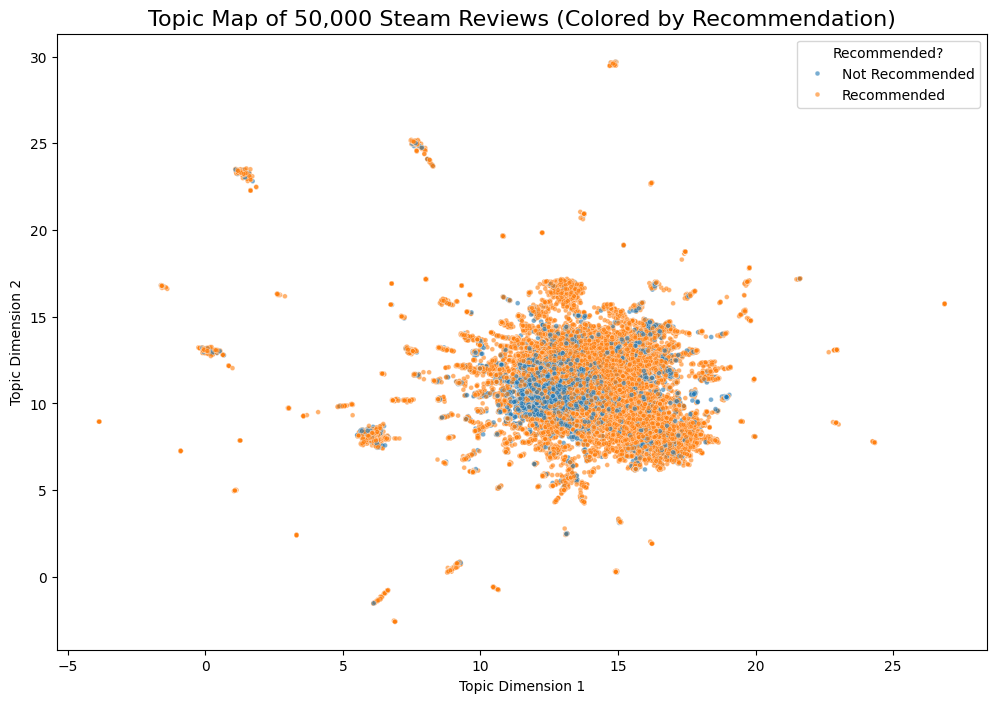

In [6]:
# Create a new DataFrame for easy plotting with Seaborn
plot_df = pd.DataFrame(emb, columns=['u1', 'u2'])
labels = sample['recommendation']
plot_df['recommended'] = labels.values

# -- Plot for Nonlinear Embedding --
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='u1', y='u2', hue='recommended', s=12, alpha=0.6)
plt.title("Topic Map of 50,000 Steam Reviews (Colored by Recommendation)", fontsize=16)
plt.xlabel("Topic Dimension 1")
plt.ylabel("Topic Dimension 2")
plt.legend(title='Recommended?')
plt.show()

From the plot above, we can see that the large cluster appears in the center of the plot, meaning that the reviews are generally similar in content.  Another thing to note is that the outliers (more niche topics) are typically reviews that do recommend the game.

Finally, let's use KMean clustering to determine the top 5 topics.


--- Top 10 Words for Each Discovered Topic ---
  Topic 1: game, 10, good, great, like, best, 2023, 2021, 2022, 2020
  Topic 2: 2021, 2020, received, product, free, good, game, yes, gud, 2023
  Topic 3: 2023, 2022, игра, lit, на, quixote, ye, yup, gas, eh
  Topic 4: access, early, review, game, fun, good, 2021, 2020, 2023, 2022
  Topic 5: game, 2023, 2022, play, good, just, 2021, like, fun, 2019

Generating Figure 2: Map with Labeled Topic Clusters...


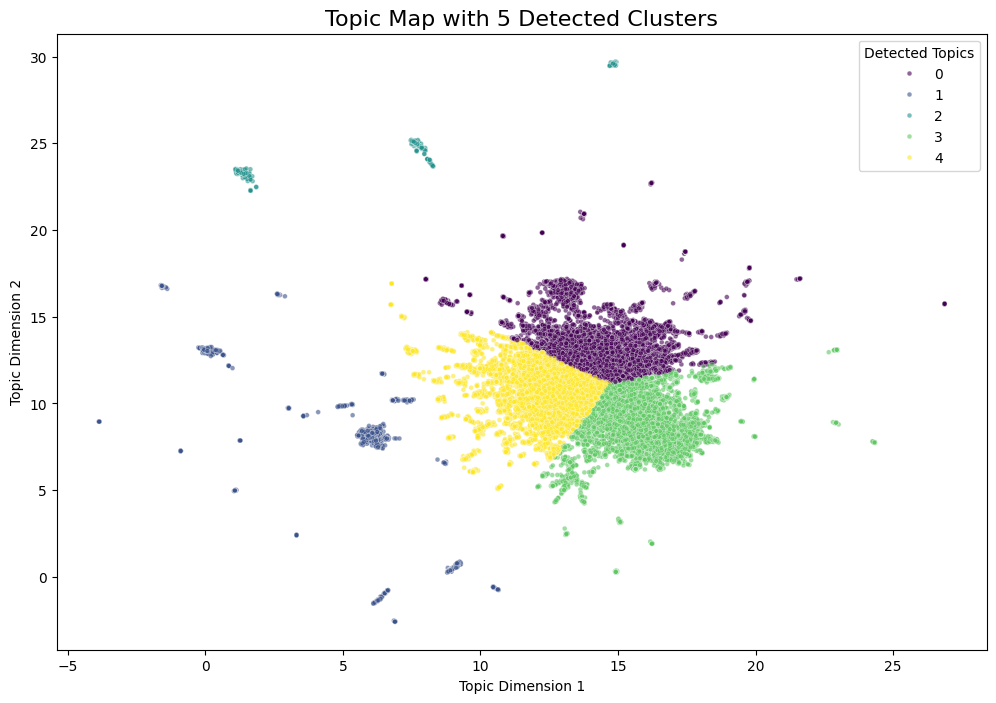

In [7]:
n_topics = 5
kmeans = KMeans(n_clusters=n_topics, random_state=42, n_init='auto')
plot_df['cluster'] = kmeans.fit_predict(plot_df[['u1', 'u2']])

# Prints the top ten words discorvered for the top 5 topics
print("\n--- Top 10 Words for Each Discovered Topic ---")
terms = vec.get_feature_names_out()
for i in range(n_topics):
    topic_vectors = V[(plot_df['cluster'] == i).values]
    mean_vector = np.mean(topic_vectors, axis=0)
    top_indices = np.asarray(mean_vector).flatten().argsort()[-10:][::-1]
    top_words = [terms[j] for j in top_indices]
    print(f"  Topic {i+1}: {', '.join(top_words)}")

# --- KMeans 2D Plot ---
print("\nGenerating Figure 2: Map with Labeled Topic Clusters...")
plt.figure(figsize=(12, 8))
sns.scatterplot(data=plot_df, x='u1', y='u2', hue='cluster', palette='viridis', s=12, alpha=0.6)
plt.title(f"Topic Map with {n_topics} Detected Clusters", fontsize=16)
plt.xlabel("Topic Dimension 1")
plt.ylabel("Topic Dimension 2")
plt.legend(title='Detected Topics')
plt.show()

From the plot, the KMean structure shows that the top 3 main topics makes up the majority of the cluster, while the other two topics are mainly outliers.  In general, we can say that most reviews revolve around the top 3 topics, and on the other hand, the more niche reviews are the other topics.